In [1]:
import sys
import os
sys.path.append('../')
from src.utils import *
import pickle
import cv2
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Load data about identities:

In [2]:
data = pd.read_table('../annotations/identity_CelebA.txt', delim_whitespace=True)
bboxes = pd.read_table('../annotations/list_bbox_celeba.txt', delim_whitespace=True)

In [3]:
data.head()

,image_id,identity
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


Number of images:

In [4]:
print(f"Based on identities file: {data.image_id.nunique()}")
print(f"Based on directory content: {len([f for f in os.listdir('../images/') if f.endswith('.jpg')])}")

Based on identities file: 202599
Based on directory content: 202599


Number of unique identifiers:

In [5]:
data.identity.nunique()

10177

The distribution of photos per person:

In [6]:
imgs_per_person = data.identity.value_counts()
print(imgs_per_person)
print(f'Avg number of photos per person: {imgs_per_person.values.mean()}')

3782    35
3227    35
2820    35
3745    34
3699    34
        ..
4274     1
1734     1
6276     1
8815     1
3786     1
Name: identity, Length: 10177, dtype: int64
Avg number of photos per person: 19.907536602142084


Text(0, 0.5, 'Individuals')

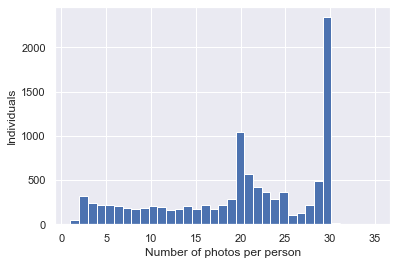

In [7]:
ax = imgs_per_person.hist(bins=35)
ax.set_xlabel("Number of photos per person")
ax.set_ylabel("Individuals")

In [8]:
print(f'Avg face width: {bboxes.width.mean()}')
print(f'Avg face height: {bboxes.height.mean()}')

Avg face width: 194.75406097759614
Avg face height: 268.92232933035206


## Data filtering

There are people with only 1 photo:

In [9]:
indices_only_1 = imgs_per_person.index[imgs_per_person == 1].tolist()
len(indices_only_1)

44

And people with only 2 photos:

In [10]:
indices_only_2 = imgs_per_person.index[imgs_per_person == 2].tolist()
len(indices_only_2)

324

Because the dataset is too big, we are going to filter data leaving people with at least 30 photos.

In [11]:
indices_over_29 = imgs_per_person.index[imgs_per_person > 29].tolist()
len(indices_over_29)

2360

In [13]:
filtered_indices = indices_over_29 + indices_only_1 + indices_only_2
filtered_ids = data[data.identity.isin(filtered_indices)].image_id.tolist()

Number of images left after cleaning:

In [43]:
cleaned_data = data.loc[data.image_id.isin(filtered_ids)]
cleaned_data.image_id.nunique()

71530

Number of unique identifiers after cleaning:

In [44]:
cleaned_data.identity.nunique()

2728

In [47]:
identity_counts = cleaned_data.groupby('identity').count()
ppl_to_be_unknown = identity_counts.loc[identity_counts.image_id <= 2].index.tolist()
cleaned_data['person'] = cleaned_data.identity.apply(lambda x: 'unknown' if x in ppl_to_be_unknown else str(x))
imgs_per_person_clean = cleaned_data.person.value_counts()
print(imgs_per_person_clean)
print(f'Avg number of photos per person: {imgs_per_person_clean.values.mean()}')

unknown    692
3227        35
2820        35
3782        35
3745        34
          ... 
5131        30
2190        30
6574        30
1611        30
5158        30
Name: person, Length: 2361, dtype: int64
Avg number of photos per person: 30.29648454044896


<ipython-input-47-d1c4f6529c3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['person'] = cleaned_data.identity.apply(lambda x: 'unknown' if x in ppl_to_be_unknown else str(x))


In [48]:
print(f'Avg face width: {bboxes[bboxes.image_id.isin(filtered_ids)].width.mean()}')
print(f'Avg face height: {bboxes[bboxes.image_id.isin(filtered_ids)].height.mean()}')

Avg face width: 231.67594016496574
Avg face height: 320.36829302390606


### Face scale analysis

In [15]:
LEFT_EYE_LOCATIONS = [(0.45, 0.45), (0.4, 0.4), (0.35, 0.35), (0.3, 0.3), (0.2, 0.2), (0.1, 0.1)]
FACE_WIDTH = 252
FACE_HEIGHT = 252

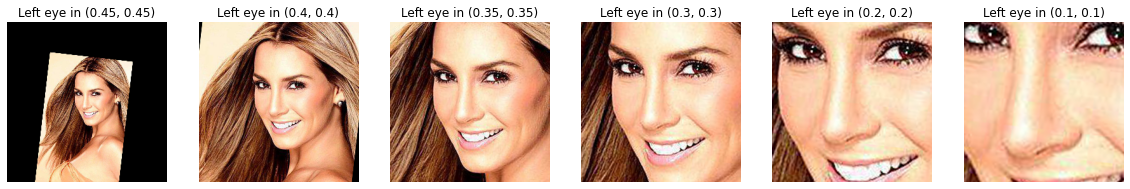

In [17]:
image, locations, eyes = detect_faces("../images/000001.jpg")
top, right, bottom, left = locations[0]
matrices = [get_rotation_matrix(eyes[0], loc, FACE_WIDTH, FACE_HEIGHT) for loc in LEFT_EYE_LOCATIONS]
imgs = [cv2.warpAffine(image, m, (FACE_WIDTH, FACE_HEIGHT), flags=cv2.INTER_CUBIC) for m in matrices]
fig, axs = plt.subplots(1, 6, figsize=(20, 10))
for i, ax in enumerate(axs):
    ax.imshow(imgs[i])
    ax.axis('off')
    ax.title.set_text(f'Left eye in {LEFT_EYE_LOCATIONS[i]}')

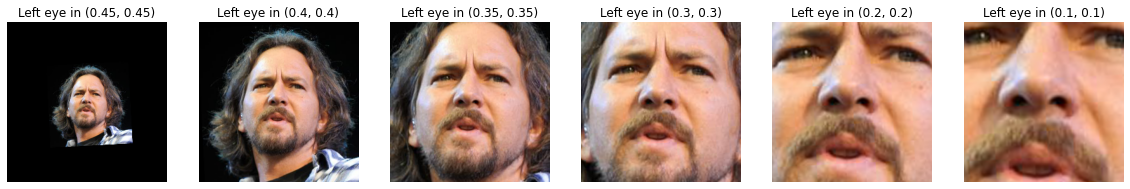

In [18]:
image, locations, eyes = detect_faces("../images/000020.jpg")
top, right, bottom, left = locations[0]
matrices = [get_rotation_matrix(eyes[0], loc, FACE_WIDTH, FACE_HEIGHT) for loc in LEFT_EYE_LOCATIONS]
imgs = [cv2.warpAffine(image, m, (FACE_WIDTH, FACE_HEIGHT), flags=cv2.INTER_CUBIC) for m in matrices]
fig, axs = plt.subplots(1, 6, figsize=(20, 10))
for i, ax in enumerate(axs):
    ax.imshow(imgs[i])
    ax.axis('off')
    ax.title.set_text(f'Left eye in {LEFT_EYE_LOCATIONS[i]}')

### Compare true and predicted bbox

In [19]:
true_boxes = pd.read_table('../annotations/list_bbox_celeba.txt', delim_whitespace=True)
true_boxes.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


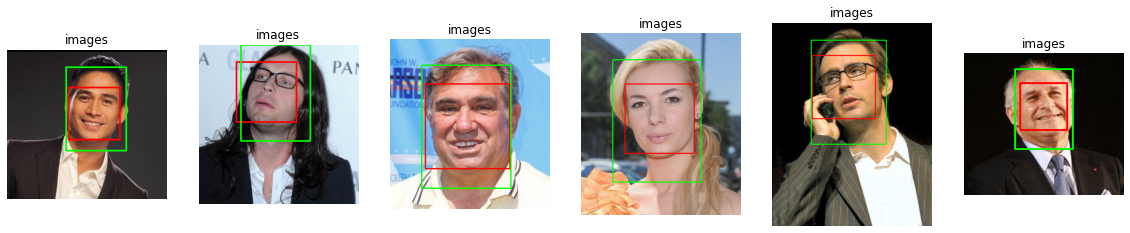

In [23]:
paths = ["../images/000012.jpg", "../images/000102.jpg", "../images/001006.jpg",
         "../images/005001.jpg", "../images/002003.jpg", "../images/003002.jpg"]
fig, axs = plt.subplots(1, 6, figsize=(20, 10))
for i, ax in enumerate(axs):
    # predicted box
    image, locations, eyes = detect_faces(paths[i])
    top, right, bottom, left = locations[0]
    image = cv2.rectangle(image, (left, bottom), (right, top), (255, 0, 0), 2)
    # true box
    box = true_boxes.loc[true_boxes.image_id == paths[i].split('/')[-1]]
    x1, y1, width, height = int(box.x_1), int(box.y_1), int(box.width), int(box.height)
    image = cv2.rectangle(image, (x1, y1 + height), (x1 + width, y1), (0, 255, 0), 2)
    ax.imshow(image)
    ax.axis('off')
    ax.title.set_text(f"{paths[i].split('/')[1]}")